In [1]:
using Interpolations
using NPZ
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall
using FFTW

In [2]:
using Printf
using Plots.PlotMeasures

In [3]:
using QuadGK

In [4]:
filepath = "/lustre/scratch4/turquoise/giannis_kx/pixie3d/iter/int_kink/11/chipar/"

"/lustre/scratch4/turquoise/giannis_kx/pixie3d/iter/int_kink/11/chipar/"

In [5]:
include("fftUtils.jl")
using .fftUtils

In [6]:
q = npzread(filepath * "q_mpi.npy");

In [7]:
Bpsi = npzread(filepath * "b_hat_rho_mpi.npy");

In [8]:
# Fourier Transform
F = fft(Bpsi,[2,3]);

In [9]:
Fn = fft(Bpsi,[3]);

In [12]:
# getting the dimensions
rdim = size(Bpsi)[1];
ufdim = size(Bpsi)[2];
fidim = size(Bpsi)[3];
tdim = size(Bpsi)[4];
time_list = LinRange(1,tdim,tdim);
psin_list = LinRange(0,1.0,rdim);
uf_list = LinRange(0,2*pi,ufdim);
fi_list = LinRange(0,2*pi,fidim);
Nn = fidim;
Nm = ufdim;

In [10]:
# Interpolating Fn to integrate it later
Fn_int = Interpolations.interpolate(Fn,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [13]:
Fn_sint = scale(Fn_int,psin_list,uf_list,1:1:fidim,time_list);

In [14]:
Fn_eint = extrapolate(Fn_sint, (Line(),Periodic(),Line(),Line()));

In [15]:
qPrime = fftUtils.q_prime(q,1/100);

In [16]:
# Construction of grid
m_grid = LinRange(fftUtils.m_mode_num((Nm+1)/2,Nm),fftUtils.m_mode_num((Nm+1)/2+1,Nm),Nm);
psi_grid = LinRange(0,1,size(F)[1]);

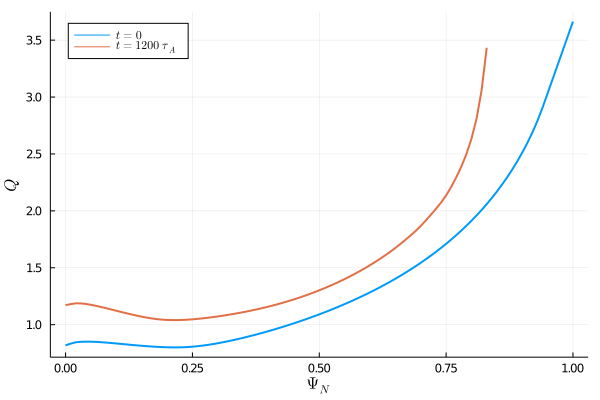

In [17]:
Plots.plot(psi_grid,-q[:,1],linewidth=2,label=L"$t=0$",legend=:topleft)
Plots.plot!(psi_grid[1:84],-q[1:84,end],linewidth=2,label=L"$t=1200\;\tau_A$")
xlabel!(L"$\Psi_N$")
ylabel!(L"$Q$")

# Integrating out the $\psi$ and $\theta$ dimension from Fn

In [18]:
function quad_psi(A_eint,psi_min,psi_max,no,to)
    res, err = quadgk(x -> A_eint(x,no,to),psi_min,psi_max)
    return res
end

quad_psi (generic function with 1 method)

In [19]:
function quad_u(A_eint,u_min,u_max,psio,no,to)
    res, err = quadgk(x -> A_eint(psio,x,no,to),u_min,u_max)
    return res
end

quad_u (generic function with 1 method)

## Integrate out the $\theta$

In [20]:
Fnp = []
for po in psin_list
    for no in 1:1:fidim
        for to in time_list
            append!(Fnp,quad_u(Fn_eint,0.0,2*pi,po,no,to))
        end
    end
end

In [21]:
Fnp = permutedims(reshape(Fnp,tdim,fidim,rdim),(3,2,1));

In [22]:
Fnp = Complex.(Fnp);

In [23]:
# Interpolate the new array
Fnp_int = Interpolations.interpolate(Fnp,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
Fnp_sint = scale(Fnp_int,psin_list,1:1:fidim,time_list);
Fnp_eint = extrapolate(Fnp_sint, (Line(),Line(),Line()));

In [24]:
Fnt = []
for no in 1:1:fidim
    for to in time_list
        append!(Fnt,quad_psi(Fnp_eint,0,1,no,to))
    end
end

In [25]:
Fnt = permutedims(reshape(Fnt,tdim,fidim),(2,1));

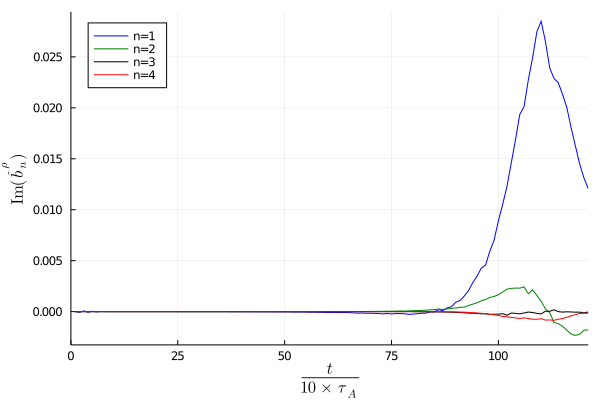

In [26]:
Plots.plot(time_list,-imag(Fnt[2,:]),xlims=(0,tdim),labels=("n=1"),color="blue",legend=:topleft)
Plots.plot!(time_list,-imag(Fnt[3,:]),xlims=(0,tdim),labels=("n=2"),color="green")
Plots.plot!(time_list,-imag(Fnt[4,:]),xlims=(0,tdim),labels=("n=3"),color="black")
Plots.plot!(time_list,-imag(Fnt[5,:]),xlims=(0,tdim),labels=("n=4"),color="red")
xlabel!(L"$\frac{t}{10 \times \tau_A}$")
ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{n})$")

In [11]:
# magnetic perturbation at time steps of most interest:
# t1: just when instability starts
# t2: during instability development
# t3: when instability saturates
# t4: long after saturation
t1 = 62;
t2 = 95;
t3 = 121; 
Bt1 = Bpsi[:,:,:,t1];
Bt2 = Bpsi[:,:,:,t2];
Bt3 = Bpsi[:,:,:,t3];
F1 = F[:,:,:,t1];
F2 = F[:,:,:,t2];
F3 = F[:,:,:,t3];

In [12]:
t1code = 600;
t2code = 920;
t3code = 1160;

In [13]:
ns,ms,maxbnm,nisl,misl,isl_width,islands = fftUtils.n_m_max(F2,q,t2);

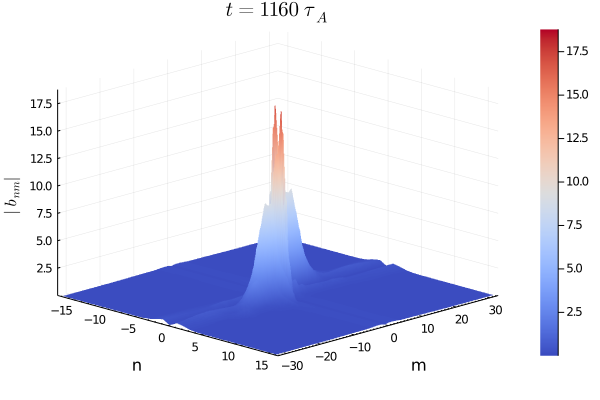

In [14]:
deg=45
Plots.scatter(ns,ms,maxbnm,zlabel=L"|b_{nm}|",camera=(deg,deg),st=:surface,c=:coolwarm, xlims=(-Nn/2,Nn/2),ylims=(-Nm/2,Nm/2),xminorticks=5,yminorticks=10)
xlabel!("n")
ylabel!("m")
title!(L"t = 1160 \; \tau_{A}")

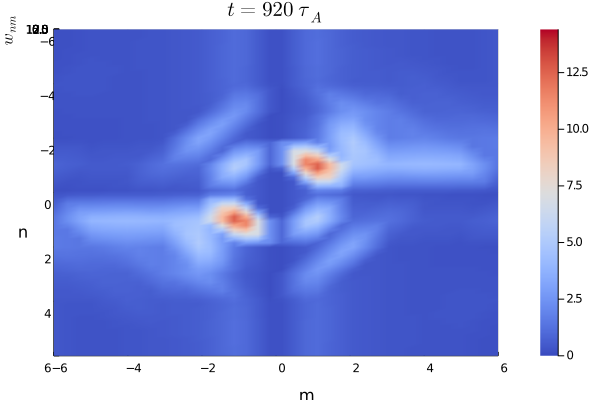

In [15]:
deg=90
Plots.scatter(nisl,misl,isl_width,zlabel=L"$w_{nm}$",camera=(deg,deg),st=:surface,c=:coolwarm #=xlims=(-(Nn/2),Nn/2),ylims=(-Nm/2,Nm/2),xminorticks=5,yminorticks=10=#,xlims=(-6,6),ylims=(-6,6),xticks=-6:2:6,yticks=-6:2:6)
xlabel!("n")
ylabel!("m")
title!(L"t = 920 \; \tau_{A}")

## Island sorting

In [29]:
sort!(islands,by = x->x[3],rev=true);

In [30]:
islands[1:20]

20-element Array{Any,1}:
 (-3, 1, 12.231357031954909)
 (3, -1, 12.231357031954909)
 (-2, 1, 8.586554311585502)
 (2, -1, 8.586554311585502)
 (-4, 1, 5.782117353651673)
 (4, -1, 5.782117353651673)
 (-1, 1, 5.674093829555903)
 (1, -1, 5.674093829555903)
 (-4, 2, 4.681615222206862)
 (4, -2, 4.681615222206862)
 (-8, 1, 4.676085046913354)
 (8, -1, 4.676085046913354)
 (-5, 2, 4.579217934473101)
 (5, -2, 4.579217934473101)
 (-1, -1, 4.261770130732513)
 (1, 1, 4.261770130732513)
 (-9, 2, 3.76996852557415)
 (9, -2, 3.76996852557415)
 (2, 1, 3.5179781035617412)
 (-2, -1, 3.517978103561741)

## Plotting of harmonics

In [32]:
# shifting the frequencies to center them to zero and reversing in the theta dimension
sF1 = fftshift(F1,2);
rsF1 = reverse(sF1,dims = 2);
sF2 = fftshift(F2,2);
rsF2 = reverse(sF2,dims = 2);
sF3 = fftshift(F3,2);
rsF3 = reverse(sF3,dims = 2);

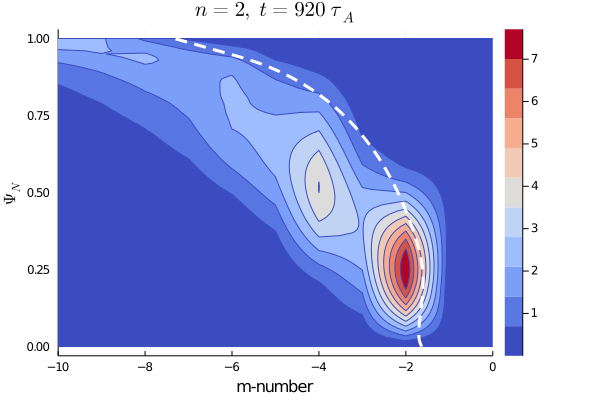

In [87]:
n_harmonic = 2
Plots.contourf(m_grid,psi_grid,abs.(rsF2[:,:,n_harmonic+1]),levels=10,c=:coolwarm,#=xlim=(-Nm/2,Nm/2)=#xlim=(-10,0),right_margin=10mm)
Plots.plot!(n_harmonic .*q[:,t1],psi_grid,linestyle=:dash,linewidth=3.0,legend=false,c=:white)
title!(L"n=2,\; t = 920 \;\tau_A")
xlabel!("m-number")
ylabel!(L"\Psi_N")

## Looking at just n=1 component close to peak

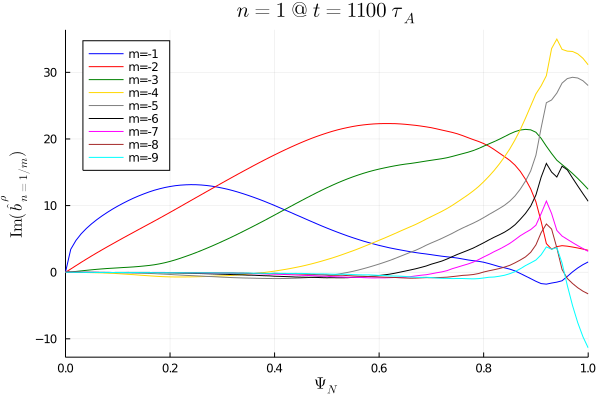

In [27]:
Plots.plot(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-1,Nm),2,110]),xlims=(0,1),labels=("m=-1"),color="blue",title=L"$n = 1\; @ \;t=1100\; \tau_A$",legend=:topleft)
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-2,Nm),2,110]),xlims=(0,1),labels=("m=-2"),color="red")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-3,Nm),2,110]),xlims=(0,1),labels=("m=-3"),color="green")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-4,Nm),2,110]),xlims=(0,1),labels=("m=-4"),color="gold")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-5,Nm),2,110]),xlims=(0,1),labels=("m=-5"),color="gray")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-6,Nm),2,110]),xlims=(0,1),labels=("m=-6"),color="black")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-7,Nm),2,110]),xlims=(0,1),labels=("m=-7"),color="magenta")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-8,Nm),2,110]),xlims=(0,1),labels=("m=-8"),color="brown")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-9,Nm),2,110]),xlims=(0,1),labels=("m=-9"),color="cyan")
xlabel!(L"$\Psi_N$")
ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{n=1/m})$")

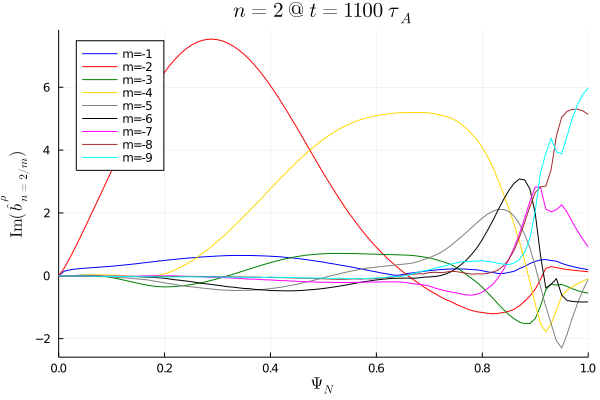

In [29]:
Plots.plot(psi_grid,abs.(F[:,fftUtils.m_mode_ind(-1,Nm),3,110]),xlims=(0,1),labels=("m=-1"),color="blue",title=L"$n = 2\; @ \;t=1100\; \tau_A$",legend=:topleft)
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-2,Nm),3,110]),xlims=(0,1),labels=("m=-2"),color="red")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-3,Nm),3,110]),xlims=(0,1),labels=("m=-3"),color="green")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-4,Nm),3,110]),xlims=(0,1),labels=("m=-4"),color="gold")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-5,Nm),3,110]),xlims=(0,1),labels=("m=-5"),color="gray")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-6,Nm),3,110]),xlims=(0,1),labels=("m=-6"),color="black")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-7,Nm),3,110]),xlims=(0,1),labels=("m=-7"),color="magenta")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-8,Nm),3,110]),xlims=(0,1),labels=("m=-8"),color="brown")
Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-9,Nm),3,110]),xlims=(0,1),labels=("m=-9"),color="cyan")
xlabel!(L"$\Psi_N$")
ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{n=2/m})$")

## Movie of modes

In [62]:
ymin = -20.0;
ymax = 10.6;
anim = Plots.Animation()
for t in 1:tdim
    Plots.plot(psi_grid,imag(F[:,fftUtils.m_mode_ind(1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=1,n=1"),legend=:bottomright)
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=2,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-3,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=-3,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-4,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=-4,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-5,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="green",labels=("m=-5,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-8,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="salmon",labels=("m=-8,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-9,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="gold",labels=("m=-9,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(-1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="black",labels=("m=-1,n=1"))
    #Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(10,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="aquamarine",labels=("m=10,n=2"))
    #Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(3,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="black",labels=("m=8,n=3"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,2,t]),xlims=(0,1),ylims=(-6.8,6.8),color="green",labels=("m=3,n=1"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,3,t]),xlims=(0,1),ylims=(-6.8,6.8),color="black",labels=("m=3,n=2"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-4,4,t]),xlims=(0,1),ylims=(-6.8,6.8),color="blue",labels=("m=5,n=3"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-7,5,t]),xlims=(0,1),ylims=(-6.8,6.8),color="magenta",labels=("m=8,n=5"))
    xlabel!(L"$\Psi_n$")
    ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")
    time=t
    annotate!((0.9,1.3,"t="*string(time*10)))
    Plots.frame(anim)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
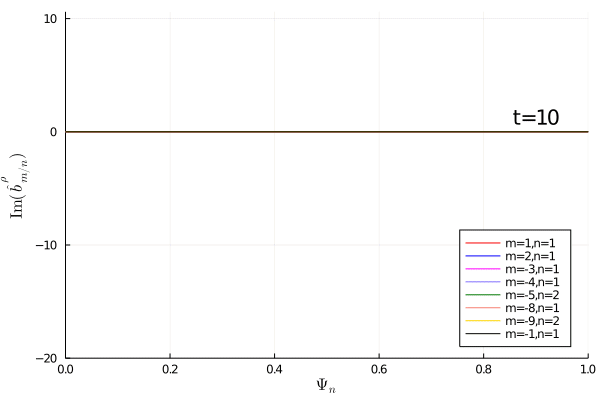

In [64]:
gif(anim,fps=10)

## More reasonable movie

In [75]:
ymin = -10.0;
ymax = 28.6;
anim = Plots.Animation()
for t in 1:tdim
    Plots.plot(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=-1,n=1"),legend=:bottomright)
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=-2,n=1"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-3,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=-3,n=1"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-4,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=-4,n=1"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-1,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="green",labels=("m=-1,n=2"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-2,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="salmon",labels=("m=-2,n=2"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-3,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="gold",labels=("m=-3,n=2"))
    Plots.plot!(psi_grid,-imag(F[:,fftUtils.m_mode_ind(-4,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="black",labels=("m=-4,n=2"))
    xlabel!(L"$\Psi_n$")
    ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")
    time=t
    annotate!((0.9,10.3,"t="*string(time*10)))
    Plots.frame(anim)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
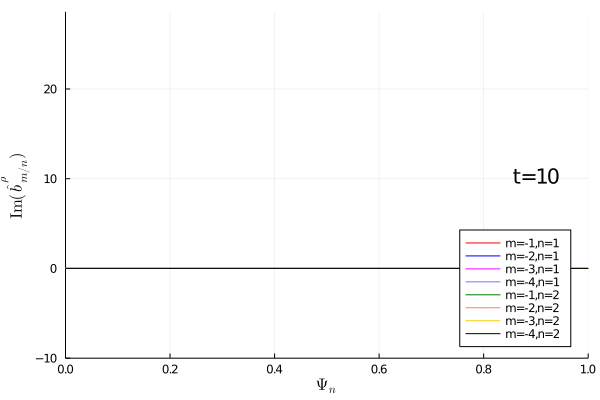

In [76]:
gif(anim,fps=10)